In [17]:
GC.gc()

include("src/utils.jl")
include("src/solver.jl")
include("src/loader.jl");

In [18]:
filename = "profiles.csv"
YEARS = [2014, 2015, 2016, 2017, 2018]
if ! @isdefined(time_profiles) || issubset(YEARS, keys(time_profiles)) == false
    time_profiles, wind_profiles, solar_profiles = load_profiles(
        filename,
        years = YEARS,
        verbose = true
    )
end;

print("Loaded profiles for years: ", keys(time_profiles), "\n")

Loaded profiles for years: Any[2018, 2014, 2017, 2016, 2015]


In [37]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000. # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 750. # € / MWh;
PRICE_PENALITY = 1. # € / kg of change in the production
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 12 * DEMAND * EELEC ;# MW

In [38]:
D = 1000.
# Aggregate the 5 years of profiles into a single profile
full_wind_profile :: Vector{Float64} = []
full_solar_profile :: Vector{Float64} = []
full_time_profile :: Vector{DateTime} = []

for year in sort!(collect(keys(wind_profiles)))
    print("Loading year $year \n")
    append!(full_time_profile, time_profiles[year])
    append!(full_wind_profile, wind_profiles[year])
    append!(full_solar_profile, solar_profiles[year])
end

print("Wind profile is of length $(length(full_wind_profile)) \n")
print("Solar profile is of length $(length(full_solar_profile)) \n")
print("5 * 24 * 365 + 24 is $(5 * 24 * 365 + 24) \n")

Loading year 2014 
Loading year 2015 
Loading year 2016 
Loading year 2017 
Loading year 2018 
Wind profile is of length 43824 
Solar profile is of length 43824 
5 * 24 * 365 + 24 is 43824 


In [39]:
# We need to update the annualized cost for the permanent installations
n_years = length(keys(wind_profiles))
cost_elec_n = COST_ELEC * n_years
cost_bat_n = COST_BAT * n_years
cost_tank_n = COST_TANK * n_years
cost_wind_n = COST_WIND * n_years
cost_solar_n = COST_SOLAR * n_years

output4 = solve(
    full_wind_profile,
    full_solar_profile,
    DEMAND,
    price_grid = PRICE_GRID,
    price_curtailing = PRICE_CURTAILING,
    price_penality = PRICE_PENALITY,
    cost_wind = cost_wind_n,
    cost_solar = cost_solar_n,
    cost_elec = cost_elec_n,
    cost_bat = cost_bat_n,
    cost_tank = cost_tank_n,
    ebat = EBAT,
    fbat = FBAT,
    eelec = EELEC,
    capa_elec_upper = CAPA_ELEC_UPPER,
    capa_bat_upper = CAPA_BAT_UPPER,
    verbose = true
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ...
Adding constraints ...
Solving the model ...
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 482070 rows, 438250 columns and 1426744 nonzeros
Model fingerprint: 0x37f27fcb
Coefficient statistics:
  Matrix range     [1e-04, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 175305 rows and 131480 columns
Presolve time: 2.30s
Presolved: 91636 rows, 350590 columns, 1255404 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Free vars  : 3981
 AA' NZ     : 7.159e+05
 Factor NZ  : 1.466e+06 (roughly 200 MB of memory)
 Factor Ops : 2.488

In [46]:
# Print the solution properties
print_solution_propreties(
    output4,
    wind = full_wind_profile,
    solar = full_solar_profile,
    time = full_time_profile,
);

Battery capacity: 600 MWh, Tank capacity: 46878 kg, Electrolyser capacity: 1720.0 kg/h
Wind capacity: 132 MW, Solar capacity: 196 MW 

Wind proportion in capacity: 0.4024390243902439 
Wind proportion in generation: 0.5734427708214785 

Total electricity needed: 2.1912e6 MWh, Total electricity produced: 2.065096e6 MWh
Total electricity imported: 224417.0 MWh, Total electricity curtailment: 96749.0 MWh 

Produced / Needed ratio : 0.9424497991967872 

Storage cost: 9.554766884899382e7, operating cost: 2.9718718177768075e8
Electrolyser cost : 208780.5495478658, electricity plant cost: 1.5621212957187846e8
Total cost: 5.491557607481009e8


In [48]:
# Get the plots
prod4, cons4, bat4, tank4 = plot_solution(
    output4,
    time = full_time_profile,
    demand = DEMAND
);

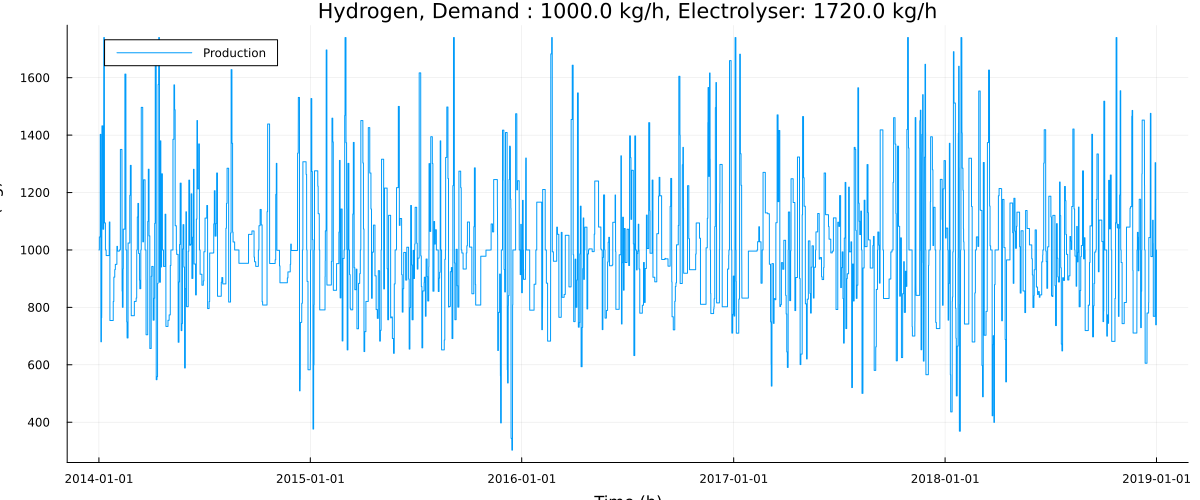

In [49]:
prod4

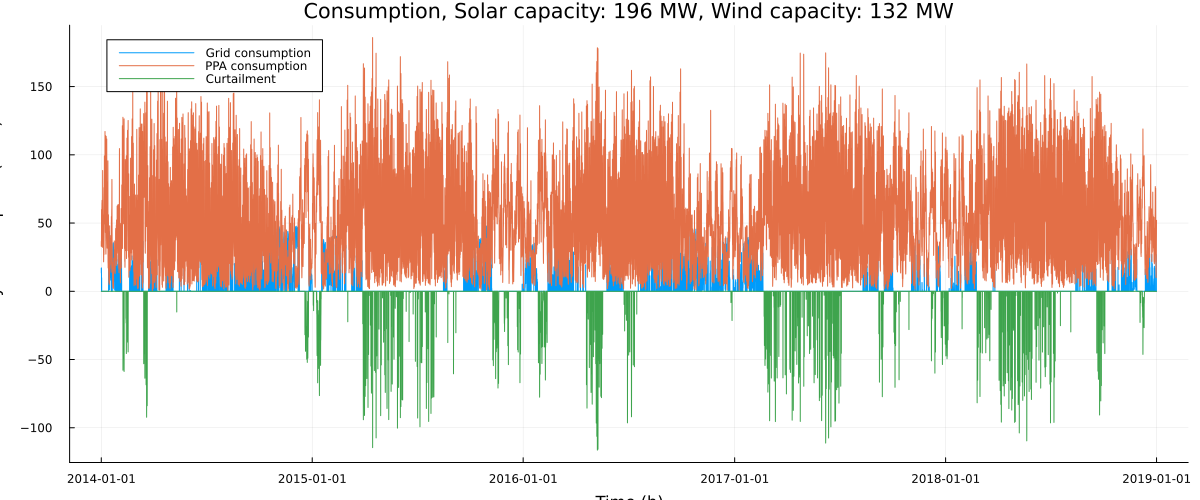

In [50]:
cons4

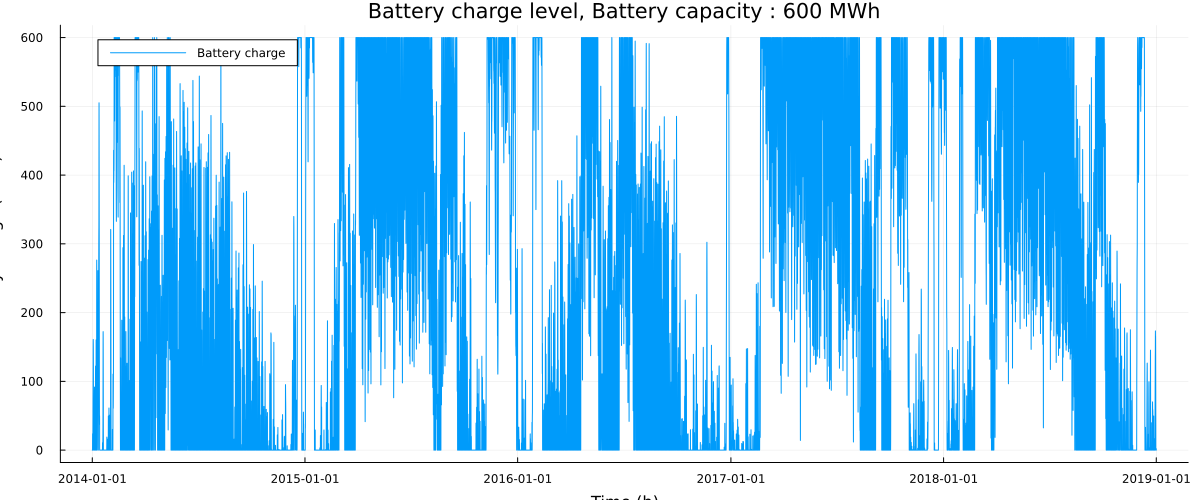

In [51]:
bat4

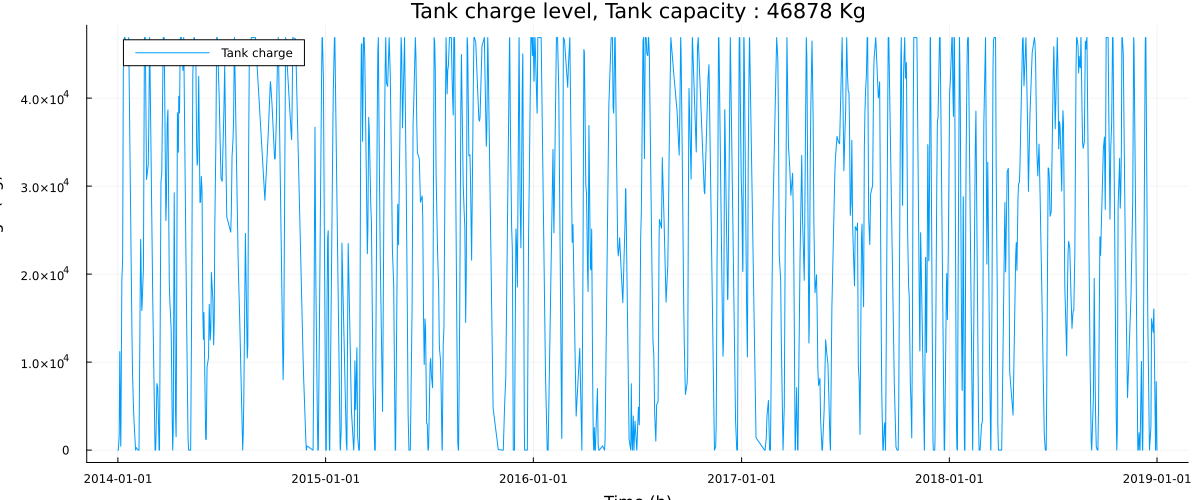

In [52]:
tank4